In [478]:
# import modules
import numpy as np
import astropy.units as u
import astropy.table as tbl
from astropy.constants import G
from ReadFile import Read
from CenterofMass import CenterOfMass
# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [611]:
class MassProfile:
# Class to define the mass profile
# of a given galaxy and simulation snapshot

    def __init__(self, galaxy, snap):
        ''' Class to calculate the mass profile of 6-D phase-space position of a galaxy's center of mass.
        
            PARAMETERS
            ----------
            galaxy: (string) A String with Galaxy Name, e.g. “MW”, “M31” or “M33”
            snap: (string) Snapshot number, e.g. 0, 1, etc
        '''
        self.filename = ilbl = "000" + str(snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename="%s_"%(galaxy) + ilbl + ".txt"
        
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             

        # store the mass, positions, velocities of only the particles of the given type
        # the following only gives the example of storing the mass
        self.m = self.data['m']
        self.x = self.data['x'] * u.kpc
        self.y = self.data['y'] * u.kpc
        self.z = self.data['z'] * u.kpc
        self.gname = galaxy

    def MassEnclosed(self, ptype, r):
        '''
        This is the function which will calculate the mass enclosed within a given radius
        of the COM position for a specified galaxy and a specified component of that galaxy.

        Inputs: 
            ptype (int) is the type of the particle, mapped to a number as follows, Type 1 = Dark Matter, 
            Type 2 = Disk Stars, Type 3 = Bulge Stars
            particle_number is the number of the particle

            r (numpy array with floats): It is the array of the magnitude of the radius.

        Outputs:
            m_array (astropy units M_sun) Mass encoded with the specified radius.
        '''

        pCom = CenterOfMass(self.filename, 2).COM_P(0.1)
        m_array = np.zeros(len(r)) 
        x_COM = self.x - pCom[0]
        y_COM = self.y - pCom[1]
        z_COM = self.z - pCom[2]
        r_COM = np.sqrt(x_COM**2 + y_COM**2 + z_COM**2)
        r = r * u.kpc
        for i in range (len(r)):
            index = np.where(r_COM < r[i])
            data1 = self.data[index]
            index1 = np.where(data1['type'] == ptype)
            data2 = data1[index1]
            mass1 = data2['m']
            m_array[i] = np.sum(mass1)


        return (m_array * 10**10 * u.M_sun)

    def MassEnclosedTotal(self, r):
        '''
        This is the function which will calculate the mass enclosed within a given radius
        of the COM position.

        Inputs: 
            r (numpy array with floats): It is the array of the magnitude of the radius.

        Outputs:
            m_array (astropy units M_sun) Mass encoded with the specified radius.
        '''
        if (self.gname == "M33"):
            array = [1, 2]
        else:
            array = [1, 2, 3]
            
        m = np.zeros(len(r)) * u.M_sun
        for ptype in array:
            m += self.MassEnclosed(ptype, r)
            

        return (m)

    def HernquistMass(self, r, a, Mhalo):
        '''

        Determines the Hernquist Mass within a given radius.

        Inputs:
            r (float): The radius
            a (int): The scale factor
            Mhalo (float): Mass of the halo

        Outputs:
            m: (float) Mass encoded with the specified radius using the Hernquist function.
        
        '''
        
        # M(r) = (Mhalo * r^2)/(a+r)^2
        mass = (Mhalo * r * r)/(a+r)**2
        return(mass)

    def CircularVelocity(self, ptype, r):
        '''
        This is the function which will calculate the circular within a given radius
        of the COM position for a specified galaxy and a specified component of that galaxy.

        Inputs: 
            ptype (int) is the type of the particle, mapped to a number as follows, Type 1 = Dark Matter, 
            Type 2 = Disk Stars, Type 3 = Bulge Stars
            particle_number is the number of the particle

            r (numpy array with floats): It is the array of the magnitude of the radius.

        Outputs:
            v_array (astropy units km/hr)Circular velocity encoded with the specified radius.
        '''

        # F = Gm1m2/r^2
        # F = mv^2/r
        # Gm/r = v^2
        G_C = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # converting units
        M_enclosed = self.MassEnclosed(ptype, r)
        Vcirc = np.round(np.sqrt(G_C*M_enclosed/(r*u.kpc)), 2)
        
        
        return Vcirc

    def CircularVelocityTotal(self, r):
        '''
        Compute the total circular velocity considering all galaxy components.
    
        Inputs:  
            r (numpy array with floats): Array of radii in kpc.
    
        Outputs:  
            v_Total (astropy units km/s): Total circular velocity encoded with the specified radius.
        '''
        
        # Select the particle types based on galaxy name
        if self.gname == "M33":
            array = [1, 2]  # Only Halo and Disk Stars
        else:
            array = [1, 2, 3]  # Halo, Disk, and Bulge Stars
    
        # Initialize total velocity squared (ensuring units are consistent)
        v_Total2 = np.zeros(len(r)) * (u.km/u.s)**2  
    
        # Sum up the square of the velocities from different components
        for ptype in array:
            v_component = self.CircularVelocity(ptype, r)
            v_component = v_component.to(u.km / u.s)  
            v_Total2 += v_component ** 2

        return np.sqrt(v_Total2)


        
    def HernquistVCirc(self, r, a, Mhalo):
        '''

        Determines the Hernquist Circular Velocity within a given radius.

        Inputs:
            r (array): The radius array
            a (int): The scale factor
            Mhalo (float): Mass of the halo

        Outputs:
            v: (astropy quantity in km/s) Velocities encoded with the specified radiusus using the Hernquist function.
        
        '''
        G_const = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        mass = self.HernquistMass(r, a, Mhalo)
        v = (G_const * mass/r*u.kpc)**0.5
        return (np.round(v, 2))


In [639]:
# Just some testing

In [613]:
MW = MassProfile("MW", "0")

In [540]:
r = np.arange(0.25, 30.5, 1.5)
r

array([ 0.25,  1.75,  3.25,  4.75,  6.25,  7.75,  9.25, 10.75, 12.25,
       13.75, 15.25, 16.75, 18.25, 19.75, 21.25, 22.75, 24.25, 25.75,
       27.25, 28.75, 30.25])

In [484]:
massDistribution = MW.MassEnclosedTotal(r)
print(massDistribution)

[1.59640000e+09 2.57516420e+10 4.12176745e+10 5.40637945e+10
 6.72522775e+10 7.98531960e+10 9.18075315e+10 1.05159795e+11
 1.20759444e+11 1.34975610e+11 1.50047710e+11 1.65038278e+11
 1.81198778e+11 1.96031299e+11 2.11437784e+11 2.26629261e+11
 2.42091718e+11 2.57165185e+11 2.69583738e+11 2.83035248e+11
 2.97175729e+11] solMass


In [485]:
print(MW.MassEnclosed(1, r))

[0.00000000e+00 1.26395200e+09 4.54232750e+09 9.20315050e+09
 1.60363910e+10 2.36991000e+10 3.14803045e+10 4.07624520e+10
 5.26909990e+10 6.34740895e+10 7.57581230e+10 8.82396490e+10
 1.02380112e+11 1.15651608e+11 1.29871068e+11 1.44169525e+11
 1.58941964e+11 1.73477412e+11 1.85563953e+11 1.98756452e+11
 2.12659924e+11] solMass


In [489]:
print(MW.MassEnclosed(2, r))

[7.9600e+08 1.9105e+10 2.9978e+10 3.7569e+10 4.3439e+10 4.7958e+10
 5.1869e+10 5.5707e+10 5.9174e+10 6.2456e+10 6.5110e+10 6.7536e+10
 6.9483e+10 7.0993e+10 7.2130e+10 7.2983e+10 7.3637e+10 7.4138e+10
 7.4444e+10 7.4682e+10 7.4901e+10] solMass


In [605]:
MW = MassProfile("MW", "0")
r = np.arange(0.1, 30.5, 0.5)
index = np.where(MW.data['type'] == 2)
Mhalo = 1.97e12
Mhalo

1970000000000.0

## Mass Distribution of Milky Way

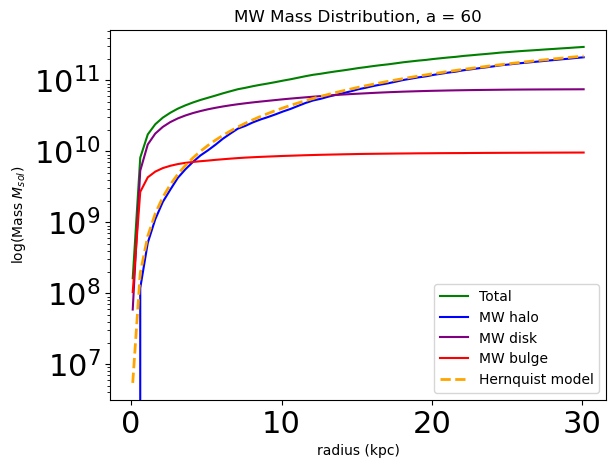

In [492]:

MWDarkMatter = MW.MassEnclosed(1, r)
MWDisk = MW.MassEnclosed(2, r)
MWBulge = MW.MassEnclosed(3, r)
massDistribution = MW.MassEnclosedTotal(r)
h = MW.HernquistMass(r, 60, Mhalo)
plt.semilogy(r, massDistribution, label='Total', c='green')
plt.semilogy(r, MWDarkMatter, label='MW halo', c='blue')
plt.semilogy(r, MWDisk, label='MW disk', c='purple')
plt.semilogy(r, MWBulge, label='MW bulge', c='red')
plt.semilogy(r,h, '--',label='Hernquist model', c='orange', linewidth=2)

plt.ylabel('log(Mass $M_{sol}$)')
plt.xlabel('radius (kpc)')
plt.title("MW Mass Distribution, a = 60")
plt.legend()

## Mass Distribution of M31

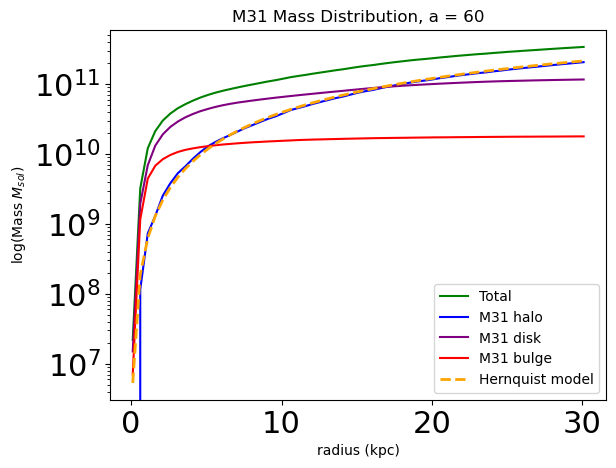

In [493]:
Mhalo = 1.921e12
M31 = MassProfile("M31", "0")
M31DarkMatter = M31.MassEnclosed(1, r)
M31Disk = M31.MassEnclosed(2, r)
M31Bulge = M31.MassEnclosed(3, r)
massDistribution = M31.MassEnclosedTotal(r)
h = M31.HernquistMass(r, 60, Mhalo)
plt.semilogy(r, massDistribution, label='Total', c='green')
plt.semilogy(r, M31DarkMatter, label='M31 halo', c='blue')
plt.semilogy(r, M31Disk, label='M31 disk', c='purple')
plt.semilogy(r, M31Bulge, label='M31 bulge', c='red')
plt.semilogy(r,h, '--',label='Hernquist model', c='orange', linewidth=2)

plt.ylabel('log(Mass $M_{sol}$)')
plt.xlabel('radius (kpc)')
plt.title("M31 Mass Distribution, a = 60")
plt.legend()

## Mass Distribution of M33

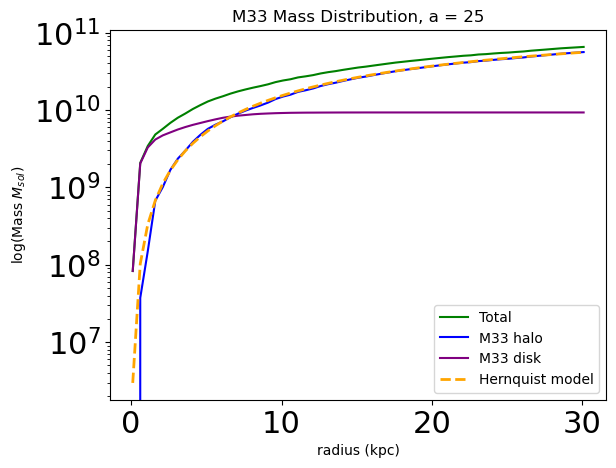

In [494]:
Mhalo = 0.187e12
M33 = MassProfile("M33", "0")
M33DarkMatter = M33.MassEnclosed(1, r)
M33Disk = M33.MassEnclosed(2, r)
massDistribution = M33.MassEnclosedTotal(r)
h = M33.HernquistMass(r, 25, Mhalo)
plt.semilogy(r, massDistribution, label='Total', c='green')
plt.semilogy(r, M33DarkMatter, label='M33 halo', c='blue')
plt.semilogy(r, M33Disk, label='M33 disk', c='purple')
plt.semilogy(r,h, '--',label='Hernquist model', c='orange', linewidth=2)

plt.ylabel('log(Mass $M_{sol}$)')
plt.xlabel('radius (kpc)')
plt.title("M33 Mass Distribution, a = 25")
plt.legend() 

# Rotation curves of MW, M31, M33

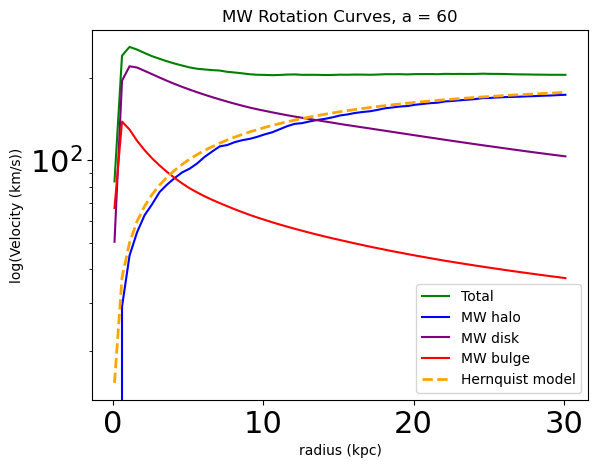

In [628]:

Mhalo = 1.97e12
MWDarkMatter = MW.CircularVelocity(1, r)
MWDisk = MW.CircularVelocity(2, r)
MWBulge = MW.CircularVelocity(3, r)
total = MW.CircularVelocityTotal(r)
h = MW.HernquistVCirc(r, 60, Mhalo)
plt.semilogy(r, total, label='Total', c='green')
plt.semilogy(r, MWDarkMatter, label='MW halo', c='blue')
plt.semilogy(r, MWDisk, label='MW disk', c='purple')
plt.semilogy(r, MWBulge, label='MW bulge', c='red')
plt.semilogy(r,h, '--',label='Hernquist model', c='orange', linewidth=2)

plt.ylabel('log(Velocity (km/s))')
plt.xlabel('radius (kpc)')
plt.title("MW Rotation Curves, a = 60")
plt.legend()

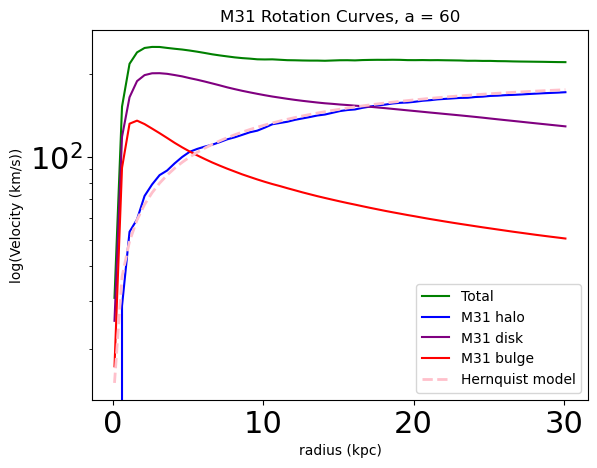

In [641]:
Mhalo = 1.921e12
M31 = MassProfile("M31", "0")
M31DarkMatter = M31.CircularVelocity(1, r)
M31Disk = M31.CircularVelocity(2, r)
M31Bulge = M31.CircularVelocity(3, r)
total = M31.CircularVelocityTotal(r)
h = M31.HernquistVCirc(r, 60, Mhalo)
plt.semilogy(r, total, label='Total', c='green')
plt.semilogy(r, M31DarkMatter, label='M31 halo', c='blue')
plt.semilogy(r, M31Disk, label='M31 disk', c='purple')
plt.semilogy(r, M31Bulge, label='M31 bulge', c='red')
plt.semilogy(r,h, '--',label='Hernquist model', c='pink', linewidth=2)

plt.ylabel('log(Velocity (km/s))')
plt.xlabel('radius (kpc)')
plt.title("M31 Rotation Curves, a = 60")
plt.legend()

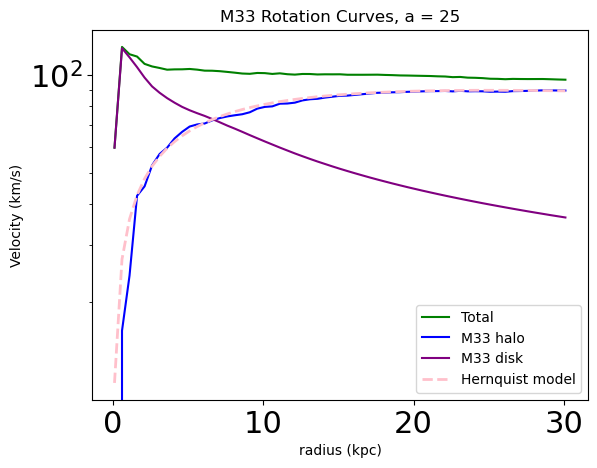

In [642]:
Mhalo = 0.187e12
M33 = MassProfile("M33", "0")
M33DarkMatter = M33.CircularVelocity(1, r)
M33Disk = M33.CircularVelocity(2, r)
total = M33.CircularVelocityTotal(r)
h = M33.HernquistVCirc(r, 25, Mhalo)
plt.semilogy(r, total, label='Total', c='green')
plt.semilogy(r, M33DarkMatter, label='M33 halo', c='blue')
plt.semilogy(r, M33Disk, label='M33 disk', c='purple')
plt.semilogy(r,h, '--',label='Hernquist model', c='pink', linewidth=2)

plt.ylabel('Velocity (km/s)')
plt.xlabel('radius (kpc)')
plt.title("M33 Rotation Curves, a = 25")
plt.legend()